In [1]:
# plot haplotypes from loopseq

import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import to_hex
from itertools import combinations
import re
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw

In [2]:
# mutation color dictionary
def all_colors():
    COLORS = {'1764T-': '#F50202', '1664AG': '#fca003', '535AG': '#5EC0D2', '1440TC': '#F1F87A', 
              '1440TG': '#bfbb71', '1443AG': '#731f1f', '1611AG': '#6988b8', '1724CT': '#8FD95A', 
              '1744AG': '#FBB3DD', '1906GA': '#A3A3A3', '3358CT': '#26451C', '3114GA': '#B37A42', 
              '1770AG': '#b3b2ad', '2310GA': '#033E86', '2626AG': '#8FD95A', '3299CT': '#211785', 
              '1718CT': '#4e0d8c', '862TC': '#880E05', '2790AT': '#DF36C6', '1736GA': '#CFFD2F', 
              '1549CT': '#cd99f2', '531GA': '#DFC236', '1050CT': '#0D2291', '1688GT': '#13B908', 
              '2356AG': '#2d16f7', '170TA': '#C60DC3', '1673AG': '#E2D492', '2859CT': '#972FFE', 
              '21TC': 'grey', '323TA': 'black', '2317GA': '#E4CEFD', '3378CT': '#828282', 
              '1735CT': '#AFF31E', '1560GA': '#646669', '1829TC': '#147040', '2731AG': '#B0F7FF', 
              '710GA': '#ad8f61', '1056CT': '#bd099f', '784AG': '#875408', '1520AG': '#92bf91', 
              '1829AG': '#6e465a'}
    return COLORS

In [3]:
# this function accepts a reads file and finds all the combination freqs
# a new df is created with all the combo freqs that were above cutoff in at least one passage
def find_combo_freqs(reads_df, mut_list, combo_list, freq_cutoff):
    passages = sorted(reads_df["passage"].drop_duplicates().to_list())
    lines = sorted(reads_df["line"].drop_duplicates().to_list())
    mut_combo_list = ["_".join(map(str, tup)) for tup in combo_list]
    all_combo_dfs = []
    for passage in passages:
        line_dfs = []
        for line in lines:
            combo_df = pd.DataFrame({"mutations": mut_combo_list})
            combo_df["line"] = line
            p_reads = reads_df.loc[((reads_df["passage"] == passage) & (reads_df["line"] == line)), :]
            total_reads = len(p_reads["read_id"].drop_duplicates())
            freqs_list = []
            for combo in combo_list:
                not_in_combo = [mut for mut in mut_list if mut not in combo]
                in_cond = p_reads["mutations"].apply(lambda row: all(mut in row if pd.notna(row) else False for mut in combo))
                out_cond = p_reads["mutations"].apply(lambda row: all(mut not in row if pd.notna(row) else False for mut in not_in_combo))
                fil_reads = p_reads.loc[in_cond & out_cond, :]
                combo_freq = len(fil_reads["read_id"]) / total_reads
                freqs_list.append(combo_freq)

            if len(freqs_list) == len(combo_list):
                combo_df["passage_{}".format(passage)] = freqs_list
                line_dfs.append(combo_df)
            else:
                print("error_passage{}_line{}".format(passage, line))

        passage_freq_df = pd.concat(line_dfs)
        all_combo_dfs.append(passage_freq_df)
    all_combo_dfs = [df.set_index(["mutations", "line"]) for df in all_combo_dfs]
    all_combo_freqs = pd.concat(all_combo_dfs, axis=1).reset_index()

    #keep combos under cutoff that include the orange/pink mutation
    orange_fil_combos = all_combo_freqs.loc[(((all_combo_freqs.iloc[:, 2:] < freq_cutoff).all(axis=1)) & 
                                             (all_combo_freqs["mutations"].str.contains("1664AG")) & 
                                             (~all_combo_freqs["mutations"].str.contains("1744AG")) & 
                                             ((all_combo_freqs.iloc[:, 2:] > 0).any(axis=1)))].reset_index(drop=True)
    pink_fil_combos = all_combo_freqs.loc[(((all_combo_freqs.iloc[:, 2:] < freq_cutoff).all(axis=1)) & 
                                           (~all_combo_freqs["mutations"].str.contains("1664AG")) & 
                                           (all_combo_freqs["mutations"].str.contains("1744AG")) & 
                                           ((all_combo_freqs.iloc[:, 2:] > 0).any(axis=1)))].reset_index(drop=True)
    # get sum of filetered orange/pink mutaions
    orange_fil_combos = orange_fil_combos.iloc[:, 1:].groupby(["line"]).sum().reset_index()
    orange_fil_combos["mutations"] = "1664AG_combos"
    pink_fil_combos = pink_fil_combos.iloc[:, 1:].groupby(["line"]).sum().reset_index()
    pink_fil_combos["mutations"] = "1744AG_combos"

    # filter combos under cutoff
    all_combo_freqs = all_combo_freqs.loc[(all_combo_freqs.iloc[:, 2:] >= freq_cutoff).any(axis=1)].reset_index(drop=True)
    all_freqs = pd.concat([all_combo_freqs, orange_fil_combos, pink_fil_combos], axis=0).reset_index(drop=True)
    #add frequency of all other mutations (other)
    freq_dif = all_freqs.iloc[:, 1:].groupby(["line"]).sum().reset_index()
    numeric_columns = freq_dif.columns.difference(["line"])
    freq_dif[numeric_columns] = 1 - freq_dif[numeric_columns]
    freq_dif["mutations"] = "other"
    all_freqs = pd.concat([all_freqs, freq_dif], axis=0).reset_index(drop=True)
    return all_freqs


# match colors for each mutation combo over cutoff
def combo_color_match(combo_freqs, no_color_dict):
    mut_combos = combo_freqs["mutations"].to_list()
    image_list = []
    for combo in mut_combos:
        mut_list = combo.split("_")
        hex_colors = []
        for mut in mut_list:
            if (mut == "combos") | (mut == "other"):
                hex_colors.append("#b1b2b5")
            elif mut in all_colors():
                hex_colors.append(all_colors()[mut])
            else:
                hex_colors.append(no_color_dict[mut])

        combo_image = create_color_sections(hex_colors)
        image_list.append(np.array(combo_image))
    return image_list


# convert hex color to rgb (for color segment images)
def hex_to_rgb(hex_color):
    # Convert hex color to RGB tuple
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


# creates an colored image for each mutation combination
def create_color_sections(hex_colors):
    width = 300
    height = 50
    col_amount = len(hex_colors)
    rgb_colors = []
    for color in hex_colors:
        rgb_colors.append(hex_to_rgb(color))
    image = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(image)
    for i, seg_color in enumerate(rgb_colors):
        draw.rectangle([i*width/col_amount, 0, (i+1)*width/col_amount, height], seg_color)
    return image

In [4]:
# create frequency plot using color images
def image_plot(freqs_df, line, experiment, images, ax):
    # export freqs of each passage from df
    freqs_list = []
    for passage in experiment[2]:
        freqs_list.append(freqs_df["passage_{}".format(passage)].to_list())
    for i, freqs in enumerate(freqs_list):
        # parameters for column locations (images are placed on plot)
        left = 1 + (i*4)
        right = left + 2
        freq_sum = 0
        for j, image in enumerate(images):
            # removes mutations with freqs under 1% to avoid segments that are too small to differ
            if (freqs[j] < 0.01) and ((j + 1) != len(freqs)):
                freqs[len(freqs) - 1] = freqs[len(freqs) - 1] + freqs[j]
                continue
            ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            # this part places the mutation combo images on the plot and adds a black border to each freq segment
            # I recommend not to change this segment even though it looks messy   
            if (freqs[j] >= 0.28):
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 301], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif (freqs[j] >= 0.18):
                image = Image.new("RGBA", (100, 100), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([0, -10, 99, 100], outline="black", width=2)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] >= 0.12:
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 298], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] >= 0.08:
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 298], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif (freqs[j] >= 0.04) and not (freqs[j] > 0.048 and freqs[j] < 0.051):
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 50], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto",
                          alpha=1.0)
            elif freqs[j] >= 0.035:
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 50], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] < 0.019:
                image = Image.new("RGBA", (100, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-4, -10, 103, 50], outline="black", width=6)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            else:
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 50], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)

            freq_sum = freq_sum + freqs[j]

    # set plot parameters
    if line == "a":
        ax.set_ylabel("Mutation Frequency [%]", fontsize=20)
    x_max = len(experiment[2]) * 4
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, 100.1)
    ax.set_facecolor("white")
    ax.set_xticks(np.arange(2, 2 + (len(experiment[2]) * 4), 4))
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xticklabels(["Passage {}".format(passage) for passage in experiment[2]], size=20)
    ax.set_title("Line {}".format(line.capitalize()), size=20)

In [5]:
# change values from 1664AG format to A1664.0G
def change_key(key):
    position = float(re.search(r'\d+', key).group())
    letter2 = key[-1]
    letter1 = key[-2]
    new_key = letter1 + str(position) + letter2
    return new_key

In [6]:
if __name__ == "__main__":
    ravit_input = r"/sternadi/home/volume3/arielle_k/noam_ravit/combo_results/ravit/filtered_reads.tsv"
    output = r"/sternadi/home/volume3/arielle_k/for_adi/paper_2024"
    mutation_list = ["535AG", "1549CT", "1664AG","1688GT" , "1718CT", "1744AG", "2859CT"] #list of all mutations to be tested for
    freq_cutoff = 0.03      #the freq cutoff for the combo freq files
    run_name = "orange_pink"   # name that will appear on files

    #get ravit & noam read files
    ravit_reads = pd.read_csv(ravit_input, sep="\t")

    # finding all the possible combinations of this set of mutations
    mut_amount = len(mutation_list) 
    combo_list = []
    for i in range(1, mut_amount+1):
        combo_list.extend(combinations(mutation_list, i))

    ravit_freqs = find_combo_freqs(ravit_reads, mutation_list, combo_list, freq_cutoff)
    ravit_lines = sorted(ravit_freqs["line"].drop_duplicates().to_list())
    ravit_passages = sorted(ravit_reads["passage"].drop_duplicates().to_list())

    i = 0
    no_color_dict = {}
    for mut in mutation_list:
        if mut not in all_colors():
            print("Mutation {} not in color dictionary, random color was assigned.".format(mut))
            cmap_b = matplotlib.colormaps['tab20']  # 'tab20b' colormap with 20 colors
            random_color = to_hex(cmap_b(i % cmap_b.N))
            no_color_dict[mut] = random_color
            i = i + 1

    exp = [ravit_freqs, ravit_lines, ravit_passages, "Ravit"]


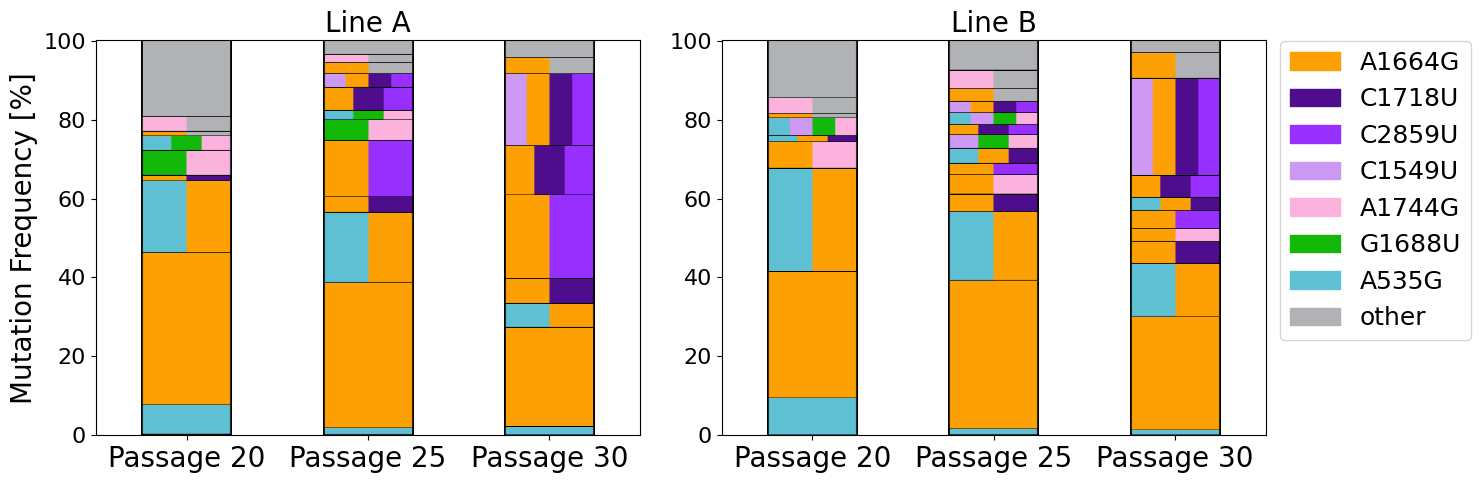

In [7]:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    for line in exp[1]:
        freqs_df = exp[0].loc[exp[0]["line"] == line, :]
        image_list = combo_color_match(freqs_df, no_color_dict)
        image_plot(freqs_df, line, exp, image_list, ax[i])
        i = i + 1

    fig.set_facecolor("white")
    color_legend = {change_key(key): all_colors()[key] for key in mutation_list if key in all_colors()}
    color_legend.update(no_color_dict)
    color_legend["other"] = "#b1b2b5"
    # set order of legend
    legend_order = ["A1664.0G", "C1718.0T", "C2859.0T", "C1549.0T", "A1744.0G", "T1829.0C", "G1688.0T", "C1735.0T", "A535.0G"]
    ordered_colors = {}
    for key in legend_order:
        if key in color_legend:
            new_key = key.replace(".0", "").replace("T", "U")
            ordered_colors[new_key] = color_legend[key]
    for key in color_legend:
        if key not in legend_order:
            new_key = key.replace(".0", "").replace("T", "U")
            ordered_colors[new_key] = color_legend[key]
    legend_patches = [mpatches.Patch(color=col, label=lab) for lab, col in ordered_colors.items()]
    plt.subplots_adjust(left=0.07, right=0.85, top=0.9, wspace=0.15)
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.4, 1.03), fontsize=18)
    plot_path = os.path.join(output, "venn_{}_{}_p{}-{}_over{}%_new.png".format(
        run_name, exp[3], exp[2][0], exp[2][len(exp[2])-1], freq_cutoff*100))
    plt.savefig(plot_path)
    plt.show()